In [19]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

from sklearn.neural_network import MLPClassifier

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense

from tensorflow.keras.optimizers import Adam
import random

In [20]:
np.set_printoptions(precision = 3)

pd.set_option("precision", 3)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

In [21]:
%matplotlib inline

In [22]:
USD_EUR = pdr.get_data_fred("DEXUSEU",
                            start = dt.datetime(2010, 1, 1),
                            end = dt.datetime(2019, 12, 31)
                            ).dropna()
USD_EUR

,DEXUSEU
DATE,
2010-01-04,1.442
2010-01-05,1.440
2010-01-06,1.440
2010-01-07,1.431
2010-01-08,1.436
...,...
2019-12-24,1.108
2019-12-26,1.110
2019-12-27,1.117


In [23]:
USD_EUR.rename(columns = {"DEXUSEU": "price"},
               inplace = True)

USD_EUR

,price
DATE,
2010-01-04,1.442
2010-01-05,1.440
2010-01-06,1.440
2010-01-07,1.431
2010-01-08,1.436
...,...
2019-12-24,1.108
2019-12-26,1.110
2019-12-27,1.117


In [24]:
USD_EUR["return"] = np.log(USD_EUR["price"] / USD_EUR["price"].shift(1)
                           )

USD_EUR["direction"] = np.where(USD_EUR["return"] > 0, 1, 0)


In [25]:
USD_EUR

,price,return,direction
DATE,,,
2010-01-04,1.442,NaN,0
2010-01-05,1.440,-0.001,0
2010-01-06,1.440,0.000,1
2010-01-07,1.431,-0.006,0
2010-01-08,1.436,0.003,1
...,...,...,...
2019-12-24,1.108,-0.001,0
2019-12-26,1.110,0.002,1
2019-12-27,1.117,0.006,1


In [26]:
lags = 5

cols = []

for lag in range(1, lags + 1): 
    col = f"lag_{lag}"
    USD_EUR[col] = USD_EUR["return"].shift(lag)
    cols.append(col)

USD_EUR.dropna(inplace = True)

In [27]:
USD_EUR

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
DATE,,,,,,,,
2010-01-12,1.452,-0.001,0,0.012,0.003,-0.006,0.000,-0.001
2010-01-13,1.449,-0.002,0,-0.001,0.012,0.003,-0.006,0.000
2010-01-14,1.448,-0.001,0,-0.002,-0.001,0.012,0.003,-0.006
2010-01-15,1.438,-0.007,0,-0.001,-0.002,-0.001,0.012,0.003
2010-01-19,1.427,-0.007,0,-0.007,-0.001,-0.002,-0.001,0.012
...,...,...,...,...,...,...,...,...
2019-12-24,1.108,-0.001,0,0.001,-0.005,0.001,-0.003,0.001
2019-12-26,1.110,0.002,1,-0.001,0.001,-0.005,0.001,-0.003
2019-12-27,1.117,0.006,1,0.002,-0.001,0.001,-0.005,0.001


In [28]:
optimizer = Adam(learning_rate = 0.0001)

In [29]:
def setting_seeds(seed = 100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)

In [30]:
setting_seeds()
model = Sequential()

In [31]:
model.add(Dense(64,
                 activation = "relu",
                 input_shape = (lags,)
                )
          )

model.add(Dense(64,
                activation = "relu")
          )

model.add(Dense(1, 
                activation = "sigmoid")
          )

In [32]:
model.compile(optimizer = optimizer,
              loss = "binary_crossentropy",
              metrics = ["accuracy"]
             )

In [33]:
cutoff = "2017-12-31"

In [34]:
training_data = USD_EUR[USD_EUR.index < cutoff].copy()
testing_data = USD_EUR[USD_EUR.index >= cutoff].copy()

In [35]:
mu, std = training_data.mean(), training_data.std()

training_data_ = (training_data - mu) / std
testing_data_ = (testing_data - mu) / std

In [36]:
%time

model.fit(training_data[cols],
          training_data["direction"],
          validation_split = 0.2,
          epochs = 50,
          verbose = False,
          shuffle = False)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.11 µs


<AxesSubplot:>

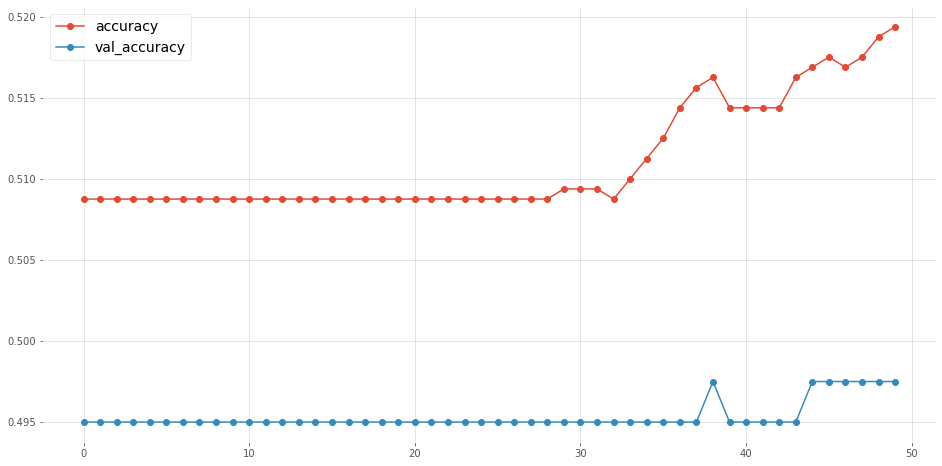

In [37]:
results = pd.DataFrame(model.history.history)

results[["accuracy", "val_accuracy"]].plot(figsize = (16, 8),
                                           style = "-o")

In [38]:
model.evaluate(training_data_[cols],
               training_data["direction"]
               )

63/63 [==============================] - 0s 1ms/step - loss: 0.8401 - accuracy: 0.5295


[0.8400746583938599, 0.5295295119285583]

In [39]:
predictions = np.where(model.predict(training_data_[cols]) > 0.5,
                       1, 0)

In [40]:
predictions[:50].flatten()

array([0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0])

In [41]:
training_data["prediction"] = np.where(predictions > 0, 1, -1)

In [42]:
training_data["strategy"] = (training_data["prediction"] * training_data["return"]
                             )

training_data[["return", "strategy"]].sum().apply(np.exp)

return     0.827
strategy   1.403
dtype: float64

<AxesSubplot:xlabel='DATE'>

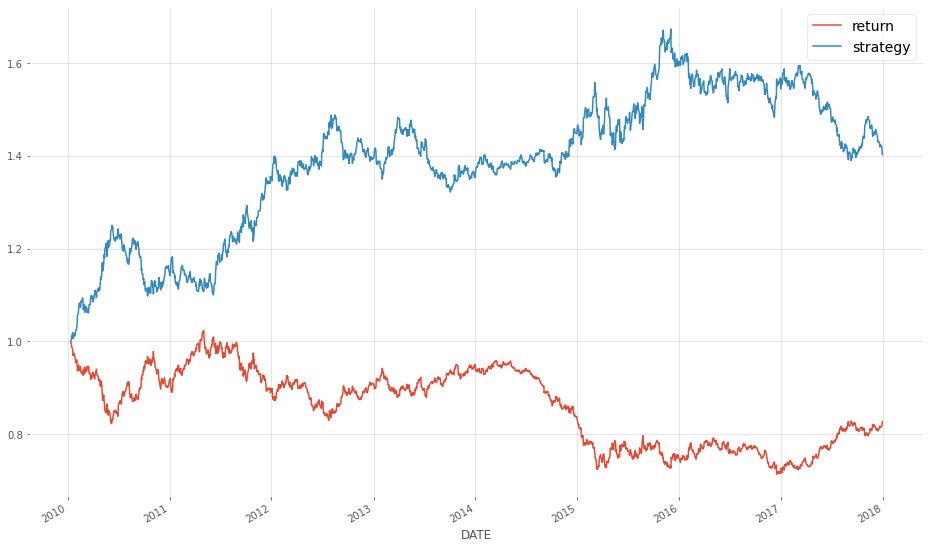

In [43]:
training_data[["return", "strategy"]].cumsum().apply(np.exp).plot(figsize = (16, 10)
                                                                  )

In [44]:
model.evaluate(testing_data_[cols],
               testing_data["direction"]
               )

16/16 [==============================] - 0s 1ms/step - loss: 0.7626 - accuracy: 0.5341


[0.7626298069953918, 0.5341365337371826]

In [45]:
predictions_test = np.where(model.predict(testing_data_[cols]) > 0.5, 
                            1, 0)

testing_data["prediction"] = np.where(predictions_test > 0, 
                                      1, 0)

testing_data["prediction"].value_counts()

0    373
1    125
Name: prediction, dtype: int64

In [46]:
testing_data["strategy"] = (testing_data["prediction"] * testing_data["return"]
                            )

testing_data[["return", "strategy"]].sum().apply(np.exp)

return     0.934
strategy   1.015
dtype: float64

<AxesSubplot:xlabel='DATE'>

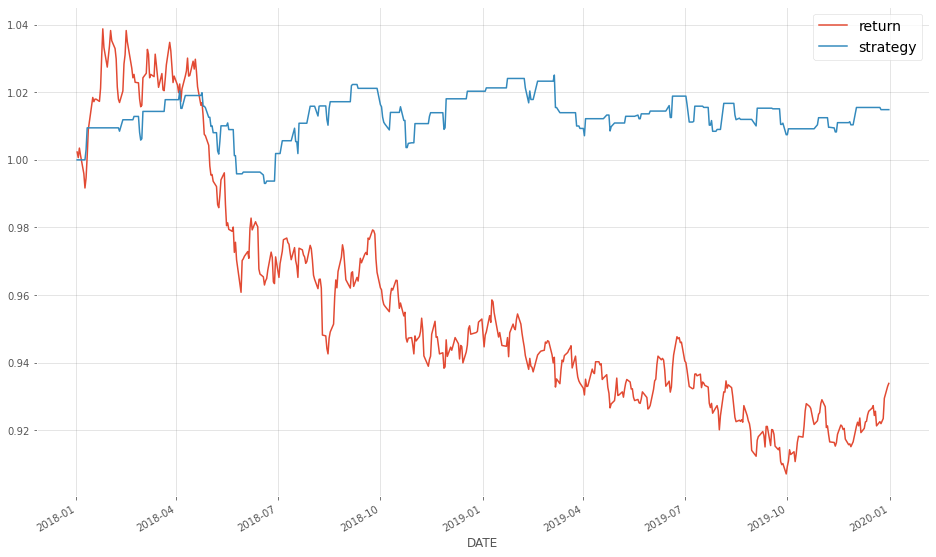

In [47]:
testing_data[["return", "strategy"]].cumsum().apply(np.exp).plot(figsize = (16, 10)
                                                               )

In [48]:
USD_EUR["momentum"] = USD_EUR["return"].rolling(5).mean().shift(1)

In [49]:
USD_EUR["volatility"] = USD_EUR["return"].rolling(22).std().shift(1)

In [50]:
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.tree import DecisionTreeRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR

# Bagging
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

# Boosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.neural_network import MLPRegressor

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest

In [52]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from tensorflow.keras.optimizers import SGD

from keras.wrappers.scikit_learn import KerasRegressor

In [53]:
import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm

In [54]:
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf

In [55]:
stock_ticker = ["MSFT", "IBM", "GOOGL"]
currency_ticker = ["DEXJPUS", "DEXUSUK"]
index_ticker = ["SP500", "DJIA", "VIXCLS"]

stock_data = pdr.DataReader(stock_ticker, "yahoo")
currency_data = pdr.DataReader(currency_ticker, "fred")
index_data = pdr.DataReader(index_ticker, "fred")

In [56]:
return_period = 5

In [57]:
Y = np.log(stock_data.loc[:, ("Adj Close", "MSFT")]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+"_pred"


In [58]:
X1 = np.log(stock_data.loc[:, ("Adj Close", ("GOOGL", "IBM")
                               )
                          ]
            ).diff(return_period)
X1.columns = X1.columns.droplevel()

X2 = np.log(currency_data).diff(return_period)
X3 = np.log(index_data).diff(return_period)

X4 = pd.concat([np.log(stock_data.loc[:, ("Adj Close", "MSFT")
                                     ]
                      ).diff(i) for i in [return_period, return_period * 3, return_period * 6, return_period * 12
                                         ]
               ], axis = 1
              ).dropna()

X4.columns = ["MSFT_DT", "MSFT_3DT", "MSFT_6DT", "MSFT_12DT"]

In [59]:
X = pd.concat([X1, X2, X3, X4], axis = 1)

In [60]:
data = pd.concat([Y, X], axis = 1).dropna().iloc[ : :return_period, :]

In [61]:
pd.concat([Y, X], axis = 1).dropna().iloc[::return_period, :]

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-04-27,0.008,0.036,-0.012,0.016,0.005,0.014,0.019,-0.312,0.041,0.041,0.053,0.061
2017-05-04,-0.005,0.069,-0.008,0.014,0.002,0.000,-0.001,0.010,0.008,0.053,0.057,0.087
2017-05-11,-0.005,0.001,-0.045,0.009,-0.002,0.002,-0.002,0.013,-0.005,0.044,0.045,0.058
2017-05-18,0.028,-0.006,0.001,-0.026,0.010,-0.012,-0.012,0.324,-0.005,-0.003,0.038,0.056
2017-05-25,0.030,0.043,0.016,0.008,-0.004,0.021,0.020,-0.384,0.028,0.017,0.071,0.075
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-15,-0.004,-0.012,0.001,0.000,-0.002,0.002,0.005,-0.031,-0.001,-0.009,0.006,0.129
2021-12-22,0.018,-0.000,0.053,0.003,0.010,-0.003,-0.005,-0.035,-0.004,0.009,-0.006,0.163
2021-12-30,-0.078,-0.001,0.032,0.007,0.007,0.011,0.012,-0.036,0.018,0.013,0.001,0.163
2022-01-10,-0.038,-0.045,-0.007,-0.001,0.007,-0.027,-0.014,0.156,-0.063,-0.030,-0.048,0.039


In [296]:
Y = data.loc[:, Y.name]
X = data.loc[:, X.columns]

In [298]:
data.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,225.000,225.000,225.000,225.000,225.000,225.000,225.000,225.000,225.000,225.000,225.000,225.000
mean,0.007,0.005,0.000,0.000,-0.000,0.003,0.002,-0.003,0.007,0.020,0.043,0.086
std,0.029,0.034,0.035,0.010,0.012,0.022,0.024,0.163,0.030,0.048,0.059,0.068
min,-0.120,-0.131,-0.157,-0.036,-0.073,-0.131,-0.164,-0.447,-0.120,-0.149,-0.238,-0.116
25%,-0.011,-0.012,-0.017,-0.005,-0.007,-0.004,-0.006,-0.090,-0.011,-0.005,0.011,0.043
50%,0.011,0.008,0.001,0.001,-0.000,0.004,0.003,-0.017,0.011,0.025,0.047,0.085
75%,0.024,0.026,0.019,0.006,0.009,0.013,0.012,0.068,0.025,0.049,0.080,0.131
max,0.077,0.089,0.092,0.037,0.055,0.059,0.079,0.992,0.077,0.147,0.244,0.306


In [299]:
data.head()


,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-04-27,0.008,0.036,-0.012,0.016,0.005,0.014,0.019,-0.312,0.041,0.041,0.053,0.061
2017-05-04,-0.005,0.069,-0.008,0.014,0.002,0.000,-0.001,0.010,0.008,0.053,0.057,0.087
2017-05-11,-0.005,0.001,-0.045,0.009,-0.002,0.002,-0.002,0.013,-0.005,0.044,0.045,0.058
2017-05-18,0.028,-0.006,0.001,-0.026,0.010,-0.012,-0.012,0.324,-0.005,-0.003,0.038,0.056
2017-05-25,0.030,0.043,0.016,0.008,-0.004,0.021,0.020,-0.384,0.028,0.017,0.071,0.075


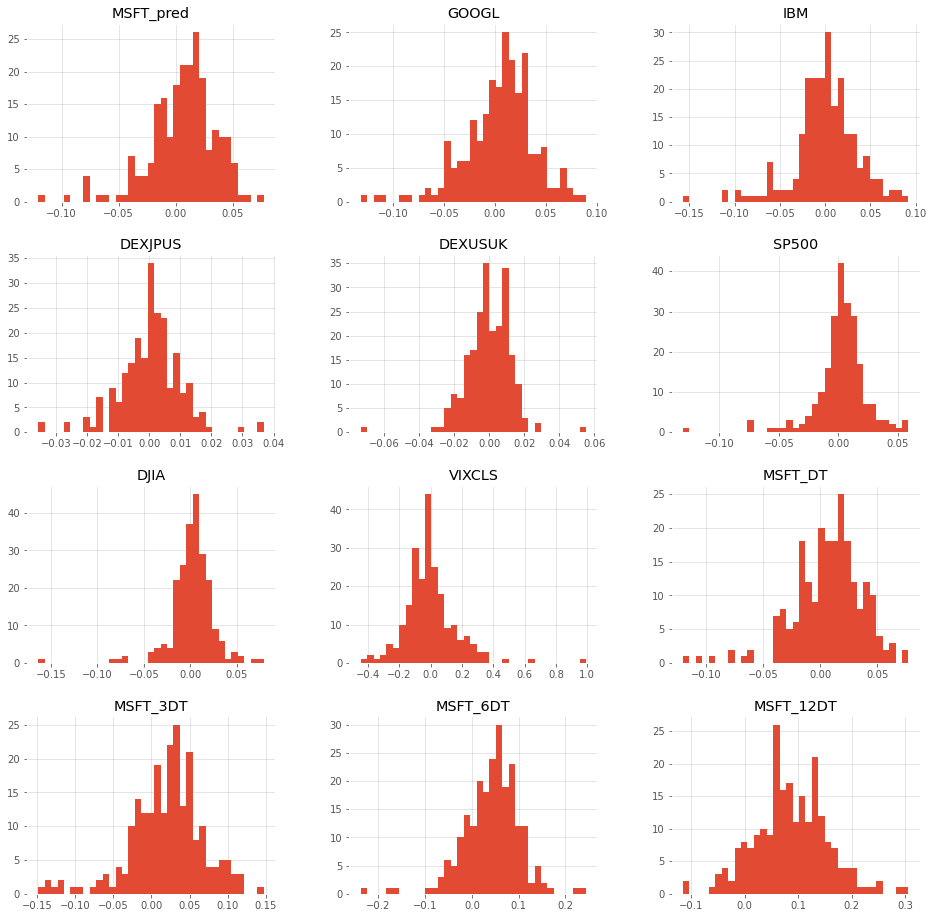

In [300]:
data.hist(bins = 35,
          sharex = False,
          sharey = False,
          figsize = (16, 16)
         )
plt.show()

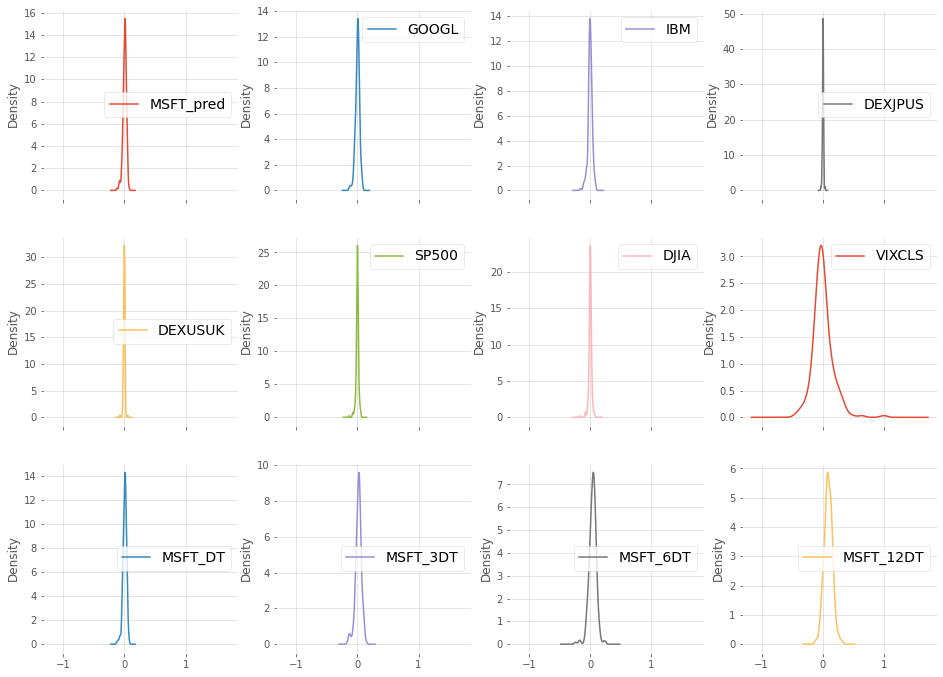

In [301]:
data.plot(kind = "density",
          subplots = True,
          layout = (4,4),
          sharex = True,
          legend = True,
          figsize = (16, 16)
         )
plt.show()

<AxesSubplot:title={'center':'Correlation Matrix'}>

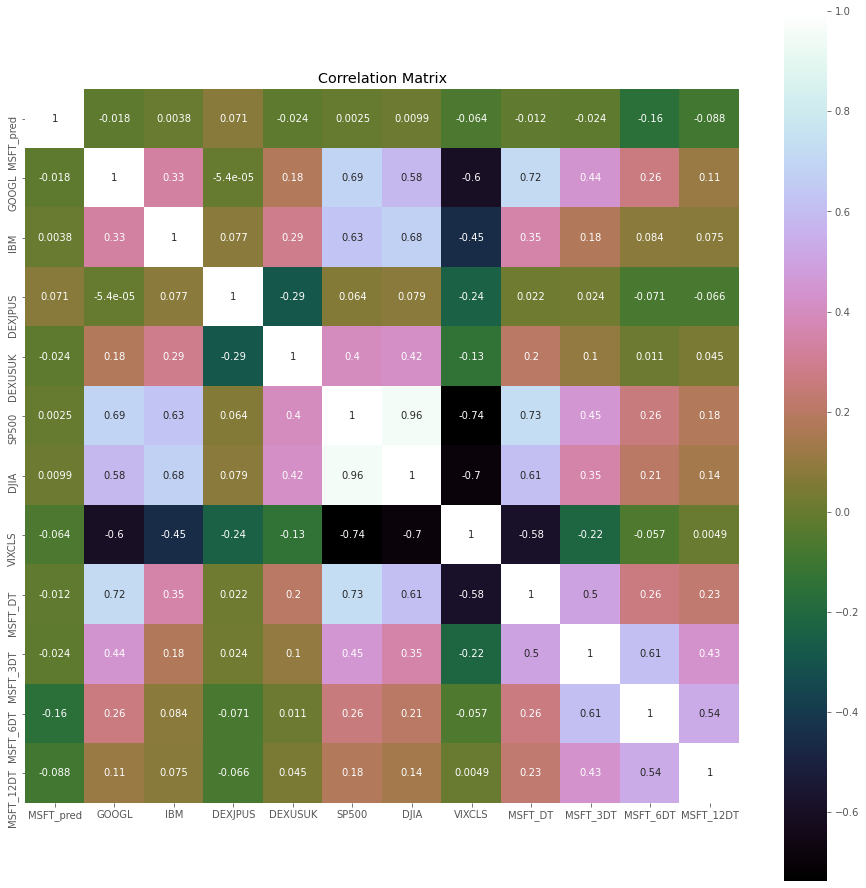

In [302]:
# sns.set_theme(style = "white")

correlation = data.corr()

plt.figure(figsize = (16, 16)
          )

plt.title("Correlation Matrix")

sns.heatmap(correlation,
            vmax = 1,
            square = True,
            annot = True,
            cmap = "cubehelix")

<Figure size 1152x1152 with 0 Axes>

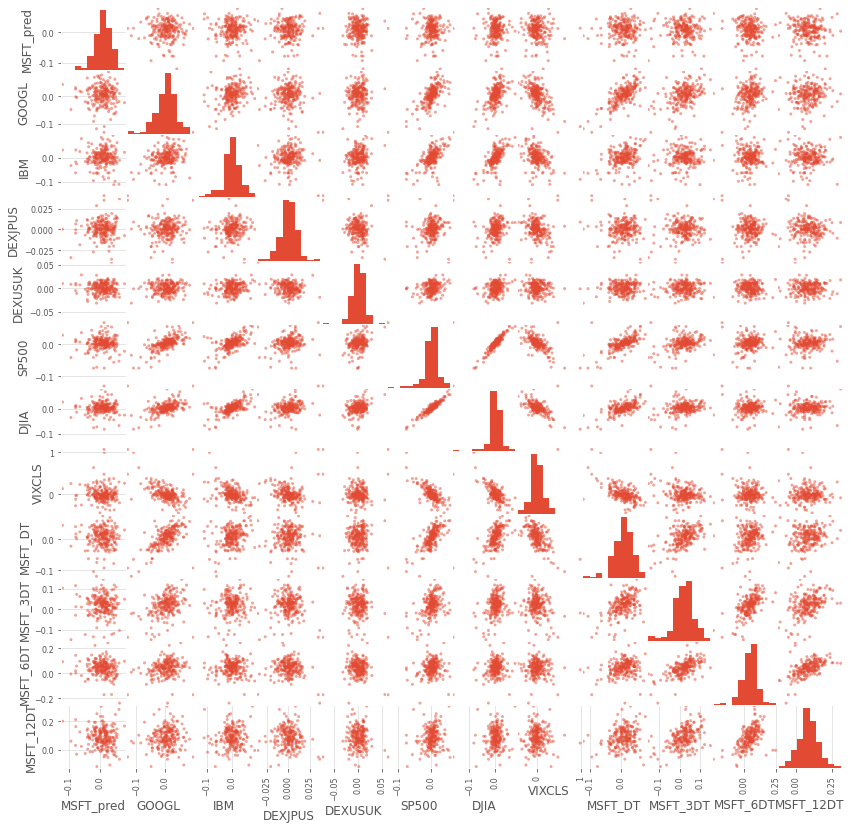

In [303]:
plt.figure(figsize = (16 ,16)
          )

scatter_matrix(data, 
               figsize = (14, 14)
              ) 

plt.show()

In [304]:
validation_size = 0.2

train_size = int(len(X) * (1 - validation_size)
                 )

X_train, X_test = X[0:train_size], X[train_size:len(X)]

Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]


### Ten-fold Cross Validation and Evaluation Metrics

In [305]:
num_folds = 10
seed = 7
scoring = "neg_mean_squared_error"


In [306]:
models = []


#### Regression and tree regression algorithms

In [307]:
models.append(("LR", LinearRegression()
              )
             )

models.append(("LASSO", Lasso()
              )
             )
    
models.append(("EN", ElasticNet()
              )
             )

models.append(("CART", DecisionTreeRegressor()
              )
             )

models.append(("KNN", KNeighborsRegressor()
              )
             )

models.append(("SVR", SVR()
              )
             )

#### Neural network algorithms

In [308]:
models.append(("MLP", MLPRegressor()
              )
             )

#### Ensemble models

In [309]:
# Bagging

models.append(("ETR", ExtraTreesRegressor()
              )
             )

models.append(("RFR", RandomForestRegressor()
              )
             )

# Boosting

models.append(("GBR", GradientBoostingRegressor()
              )
             )

models.append(("ABR", AdaBoostRegressor()
              )
             )

In [310]:
import warnings

In [311]:
warnings.filterwarnings("ignore")

## -k-fold analysis

In [312]:
#cross validation within models

names = []

kfold_results = []

train_results = []
test_results = []

for name, model in models:
    names.append(name)
    
    
     
    kfold = KFold(n_splits = num_folds,
                  random_state = seed)
    

    cv_results = -1 * cross_val_score(model, X_train, Y_train,
                                      cv = kfold,
                                      scoring = scoring)
    
    kfold_results.append(cv_results) 
    

    
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)

     
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    
    print(message)

LR: 0.000962 (0.000736) 0.000792 0.000911
LASSO: 0.000841 (0.000553) 0.000837 0.000828
EN: 0.000841 (0.000553) 0.000837 0.000828
CART: 0.001745 (0.000532) 0.000000 0.001503
KNN: 0.000979 (0.000539) 0.000656 0.000794
SVR: 0.001692 (0.000673) 0.001683 0.001442
MLP: 0.001694 (0.001198) 0.001094 0.000947
ETR: 0.001054 (0.000719) 0.000000 0.000984
RFR: 0.001019 (0.000657) 0.000141 0.001005
GBR: 0.001150 (0.000768) 0.000097 0.001163
ABR: 0.000979 (0.000691) 0.000452 0.000991


#### Comparing the algorithms by examining the cross validation results

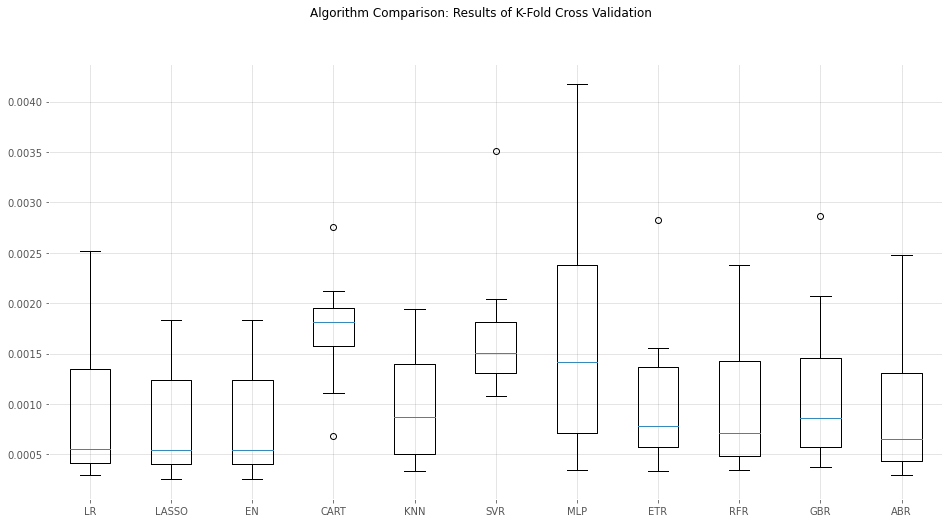

In [313]:
fig = plt.figure(figsize = (16, 8)
                 )

fig.suptitle("Algorithm Comparison: Results of K-Fold Cross Validation")

ax = fig.add_subplot(111)

plt.boxplot(kfold_results)

ax.set_xticklabels(names)

plt.show()



#### ARIMA

In [314]:
X_train_ARIMA = X_train.loc[:, ["GOOGL", "IBM", "DEXJPUS", "SP500", "DJIA", "VIXCLS"]
                            ]

X_test_ARIMA = X_test.loc[:, ["GOOGL", "IBM", "DEXJPUS", "SP500", "DJIA", "VIXCLS"]
                          ]

train_len = len(X_train_ARIMA)
test_len = len(X_test_ARIMA)
total_len = len(X)


In [315]:
modelARIMA = stats.ARIMA(endog= Y_train, exog = X_train_ARIMA, order = [1, 0, 0]
                         )

model_fit = modelARIMA.fit()


In [316]:
error_Training_ARIMA = mean_squared_error(Y_train,
                                          model_fit.fittedvalues)

predicted = model_fit.predict(start = train_len -1, 
                              end = total_len - 1, 
                              exog = X_test_ARIMA)[1:]

error_Test_ARIMA = mean_squared_error(Y_test,
                                      predicted)

error_Test_ARIMA

0.0009090391123866582

### Comparison of Algorithms

In [317]:
test_results.append(error_Test_ARIMA)

train_results.append(error_Training_ARIMA)

names.append("ARIMA")

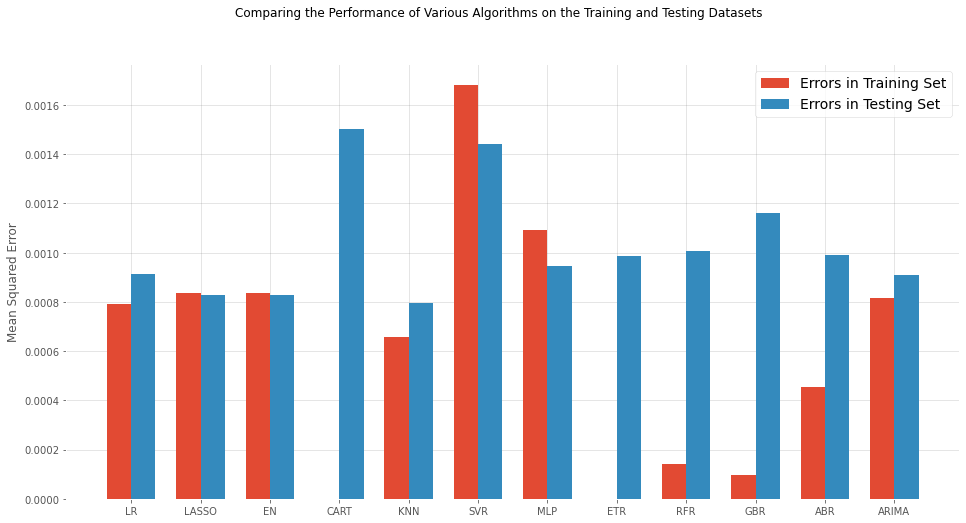

In [318]:
fig = plt.figure(figsize = (16, 8)
                 )

ind = np.arange(len(names)
               ) 
width = 0.35

fig.suptitle("Comparing the Performance of Various Algorithms on the Training and Testing Datasets")
ax = fig.add_subplot(111)

plt.bar(ind - width/2, 
        train_results, 
        width = width,
        label = "Errors in Training Set")

plt.bar(ind + width/2, 
        test_results, 
        width = width,
        label = "Errors in Testing Set")

plt.legend()

ax.set_xticks(ind)
ax.set_xticklabels(names)

plt.ylabel("Mean Squared Error")

plt.show()